[Info] Backend: FakeNairobiV2 (fallback)
[Info] Par físico conectado: (0, 1)

[Matriz de confusión A]
[[0.9225 0.0576 0.019  0.0014]
 [0.0581 0.9213 0.0013 0.0163]
 [0.0182 0.0011 0.9261 0.0572]
 [0.0012 0.02   0.0536 0.9251]]
cond(A) = 1.18e+00  (más bajo = mejor)

[Circuito transpileado]
global phase: π/4
         ┌─────────┐┌────┐┌─────────┐     ┌─┐   
q_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├──■──┤M├───
         └─────────┘└────┘└─────────┘┌─┴─┐└╥┘┌─┐
q_1 -> 1 ────────────────────────────┤ X ├─╫─┤M├
                                     └───┘ ║ └╥┘
    c: 2/══════════════════════════════════╩══╩═
                                           0  1 

=== Resultados (Bell state) ===
Shots: 8000
Counts sin mitigación : {'00': 3757, '11': 3640, '10': 312, '01': 291}
Probs  sin mitigación : {'00': 0.469625, '11': 0.455, '10': 0.039, '01': 0.036375}
Probs  mitigadas      : {'00': 0.5077583059323603, '01': 0.0, '10': 0.0017315574264946127, '11': 0.490510136641145}
Ideal                 : {'00': 0.

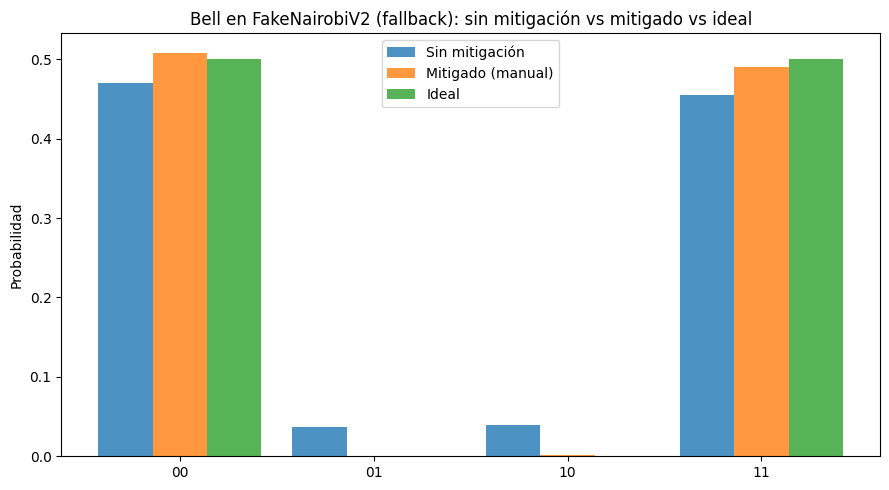

In [4]:
# =========================================================
# Mitigación de medida (readout) sin mthree — FakeTorino
# =========================================================
# Idea: calibrar la matriz de confusión midiendo 00,01,10,11 y después
# invertirla para corregir las probabilidades observadas.
# =========================================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

# --------- Intento robusto de cargar un FakeBackend "Torino" ----------
FakeBackend = None
backend_label = None

# Nuevas rutas (qiskit-ibm-runtime fake_provider, sufijo V2)
try:
    from qiskit_ibm_runtime.fake_provider import FakeTorinoV2 as FB
    FakeBackend, backend_label = FB, "FakeTorinoV2"
except Exception:
    try:
        # Ruta clásica (puede no existir en versiones recientes)
        from qiskit.providers.fake_provider import FakeTorino as FB
        FakeBackend, backend_label = FB, "FakeTorino"
    except Exception:
        # Fallbacks comunes (por si Torino no está disponible)
        try:
            from qiskit_ibm_runtime.fake_provider import FakeNairobiV2 as FB
            FakeBackend, backend_label = FB, "FakeNairobiV2 (fallback)"
        except Exception:
            from qiskit_ibm_runtime.fake_provider import FakeManilaV2 as FB
            FakeBackend, backend_label = FB, "FakeManilaV2 (fallback)"

# -------------------- Utilidades --------------------
BASIS2 = ["00", "01", "10", "11"]  # orden base para vectores 2 qubits

def pick_connected_edge(backend):
    """Devuelve (u, v) qubits físicos conectados."""
    try:
        edges = backend.coupling_map.get_edges()  # V2
    except Exception:
        edges = backend.configuration().coupling_map  # V1
    if not edges:
        raise RuntimeError("El backend no tiene coupling map.")
    u, v = edges[0]
    return int(u), int(v)

def counts_to_probs(counts):
    shots = max(1, sum(counts.values()))
    return {k: v / shots for k, v in counts.items()}

def normalize_probs(probs, n_qubits=2):
    """Normaliza y garantiza claves binarias de longitud n_qubits."""
    out = defaultdict(float)
    total = 0.0
    if isinstance(probs, dict):
        for k, v in probs.items():
            key = format(k, f"0{n_qubits}b") if isinstance(k, int) else str(k)
            out[key] += float(v)
            total += float(v)
    elif isinstance(probs, (list, np.ndarray)):
        for i, v in enumerate(probs):
            key = format(i, f"0{n_qubits}b")
            out[key] += float(v)
            total += float(v)
    else:
        raise TypeError("formato de probs no reconocido")
    if total > 0:
        for k in out:
            out[k] /= total
    # Completar los estados faltantes
    for i in range(2**n_qubits):
        key = format(i, f"0{n_qubits}b")
        out[key] += 0.0
    return dict(out)

def probs_vec_from_counts(counts, basis=BASIS2):
    """Convierte counts/probs a vector en el orden dado por 'basis'."""
    if isinstance(counts, dict):
        probs = counts_to_probs(counts)
    else:
        probs = counts
    probs = normalize_probs(probs, n_qubits=len(basis[0]))
    return np.array([probs.get(s, 0.0) for s in basis], dtype=float)

def build_calibration_circuits(u, v):
    """Devuelve 4 circuitos que preparan 00, 01, 10, 11 (en orden BASIS2) y miden."""
    circs = []
    for state in BASIS2:
        qr = QuantumRegister(2, "q")
        cr = ClassicalRegister(2, "c")
        qc = QuantumCircuit(qr, cr)
        # state[0] corresponde al qubit "alto" (q1), state[1] al "bajo" (q0) en bitstrings
        if state[0] == "1":
            qc.x(qr[1])
        if state[1] == "1":
            qc.x(qr[0])
        qc.measure(qr, cr)
        circs.append(qc)
    return circs

def estimate_confusion_matrix(sim, backend, u, v, shots=20000, opt_level=3):
    """
    Construye la matriz 4x4 A tal que p_measured ≈ A @ p_true.
    Columnas: estados preparados (00,01,10,11).
    Filas: estados medidos (00,01,10,11).
    """
    cal_circs = build_calibration_circuits(u, v)
    cal_transpiled = [transpile(c, backend=sim, initial_layout=[u, v], optimization_level=opt_level)
                      for c in cal_circs]
    job = sim.run(cal_transpiled, shots=shots)
    result = job.result()

    A = np.zeros((4, 4), dtype=float)
    for col, c in enumerate(cal_transpiled):
        counts = result.get_counts(c)
        p_meas = probs_vec_from_counts(counts, BASIS2)  # vector 4
        A[:, col] = p_meas
    return A

def mitigate_probs(p_raw, A, clip_eps=1e-12):
    """
    Dado p_raw (vector 4) y matriz A (4x4), estima p_true ≈ A^+ p_raw.
    Usa pseudo-inversa para estabilidad; luego recorta y renormaliza.
    """
    A_pinv = np.linalg.pinv(A, rcond=1e-8)
    p_corr = A_pinv @ p_raw
    # corrige negatividades numéricas y renormaliza
    p_corr = np.clip(p_corr, 0.0, 1.0)
    s = p_corr.sum()
    if s < clip_eps:
        # Si algo salió muy mal, vuelve a uniforme
        p_corr = np.ones_like(p_corr) / len(p_corr)
    else:
        p_corr /= s
    return p_corr

def exp_ZZ_from_probs_dict(probs_dict):
    """⟨ZZ⟩ para 2 qubits a partir de probs en dict."""
    exp = 0.0
    for bitstr, p in probs_dict.items():
        z = 1
        for b in bitstr:  # '0'->+1, '1'->-1
            z *= (1 if b == "0" else -1)
        exp += z * p
    return float(exp)

def total_variation_distance(p, q):
    """TVD = 0.5 * sum_i |p_i - q_i| (entradas como dicts)"""
    keys = set(p) | set(q)
    return 0.5 * sum(abs(p.get(k,0) - q.get(k,0)) for k in keys)

def plot_bar_dists(p_raw, p_mitig, p_ideal, title="Distribuciones"):
    keys = BASIS2[:]  # ['00','01','10','11']
    x = np.arange(len(keys)); w = 0.28
    plt.figure(figsize=(9,5))
    plt.bar(x - w, [p_raw.get(k,0) for k in keys], width=w, label="Sin mitigación", alpha=0.8)
    plt.bar(x,     [p_mitig.get(k,0) for k in keys], width=w, label="Mitigado (manual)", alpha=0.8)
    plt.bar(x + w, [p_ideal.get(k,0) for k in keys], width=w, label="Ideal", alpha=0.8)
    plt.xticks(x, keys); plt.ylabel("Probabilidad"); plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()

# ------------------ Main demo ------------------
def main():
    backend = FakeBackend()
    print(f"[Info] Backend: {backend_label}")
    sim = AerSimulator.from_backend(backend)

    # Elegimos un par de qubits físicos conectados
    u, v = pick_connected_edge(backend)
    print(f"[Info] Par físico conectado: ({u}, {v})")

    # (1) Calibración de lectura
    A = estimate_confusion_matrix(sim, backend, u, v, shots=20000)
    cond = np.linalg.cond(A)
    print("\n[Matriz de confusión A]")
    print(np.round(A, 4))
    print(f"cond(A) = {cond:.2e}  (más bajo = mejor)")

    # (2) Circuito Bell (|Φ+>)
    qr = QuantumRegister(2, "q")
    cr = ClassicalRegister(2, "c")
    qc = QuantumCircuit(qr, cr)
    qc.h(qr[0]); qc.cx(qr[0], qr[1])
    qc.measure(qr, cr)

    qc_t = transpile(qc, backend=sim, initial_layout=[u, v], optimization_level=3)
    print("\n[Circuito transpileado]")
    print(qc_t)

    # Ejecutar SIN mitigación
    shots = 8000
    res = sim.run(qc_t, shots=shots).result()
    counts_raw = res.get_counts()
    p_raw_dict = normalize_probs(counts_to_probs(counts_raw), n_qubits=2)

    # (3) Aplicar mitigación manual: p_corr = A^+ p_raw
    p_raw_vec = probs_vec_from_counts(p_raw_dict, BASIS2)
    p_corr_vec = mitigate_probs(p_raw_vec, A)
    p_corr_dict = {s: float(p_corr_vec[i]) for i, s in enumerate(BASIS2)}

    # (4) Métricas vs ideal
    p_ideal = {"00":0.5, "01":0.0, "10":0.0, "11":0.5}

    zz_raw   = exp_ZZ_from_probs_dict(p_raw_dict)
    zz_mitig = exp_ZZ_from_probs_dict(p_corr_dict)
    zz_ideal = exp_ZZ_from_probs_dict(p_ideal)

    tvd_raw   = total_variation_distance(p_raw_dict, p_ideal)
    tvd_mitig = total_variation_distance(p_corr_dict, p_ideal)

    print("\n=== Resultados (Bell state) ===")
    print(f"Shots: {shots}")
    print(f"Counts sin mitigación : {counts_raw}")
    print(f"Probs  sin mitigación : {p_raw_dict}")
    print(f"Probs  mitigadas      : {p_corr_dict}")
    print(f"Ideal                 : {p_ideal}")

    print("\n— Expectación <ZZ> —")
    print(f"  Ideal      : {zz_ideal:+.4f}")
    print(f"  Sin mitig. : {zz_raw:+.4f}")
    print(f"  Mitigado   : {zz_mitig:+.4f}")

    print("\n— Distancia de variación total (TVD) vs Ideal —")
    print(f"  Sin mitig. : {tvd_raw:.4f}")
    print(f"  Mitigado   : {tvd_mitig:.4f}")

    # (5) Gráfica
    plot_bar_dists(p_raw_dict, p_corr_dict, p_ideal,
                   title=f"Bell en {backend_label}: sin mitigación vs mitigado vs ideal")

if __name__ == "__main__":
    main()
